In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.formula.api import ols
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, shapiro, levene, kruskal

In [2]:
data = pd.read_csv('data.csv')
data["keywords per 100 pages"] = data["total_kw/length"] * 100
data.head()

,Code,Journal,Year,Length,Advocacy,autonomy,care_planning,communication,decision_support,education,...,QOL sum,quality_of_care,respect,role_of_family,SDM com,social_support,values,total_kw,total_kw/length,keywords per 100 pages
0,0,ACC,2023,113,0,0,0,0,0,0,...,1,1,0.0,10,0,0,0,16,0.141593,14.159292
1,0,ACC,2023,74,0,0,0,7,1,20,...,0,2,0.0,0,0,3,5,69,0.932432,93.243243
2,1,ACC,2022,131,0,0,0,0,1,2,...,0,1,0.0,0,0,0,4,37,0.282443,28.244275
3,2,ACC,2022,108,0,0,3,8,0,13,...,4,11,1.0,0,0,4,8,118,1.092593,109.259259
4,3,ACC,2021,73,0,1,0,0,0,10,...,0,4,3.0,0,0,2,4,44,0.602740,60.273973


In [3]:
# Group by 'Journal' and calculate mean and standard deviation
summary_stats = data.groupby('Journal')['keywords per 100 pages'].agg(['mean', 'std']).reset_index()

# Rename columns for clarity (optional)
summary_stats = summary_stats.rename(columns={'mean': 'Mean: keywords per 100 pages', 
                                              'std': 'Std: keywords per 100 pages'})

# Calculate the sample size for each group
summary_stats["Sample size"] = data["Journal"].value_counts().values

summary_stats

,Journal,Mean: keywords per 100 pages,Std: keywords per 100 pages,Sample size
0,ACC,43.149540,41.939114,89
1,AHA,47.638000,50.590110,67
2,ESC,20.684339,38.256694,58


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11560\1327715981.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set1', len(journals))  # Use a broader palette with enough colors


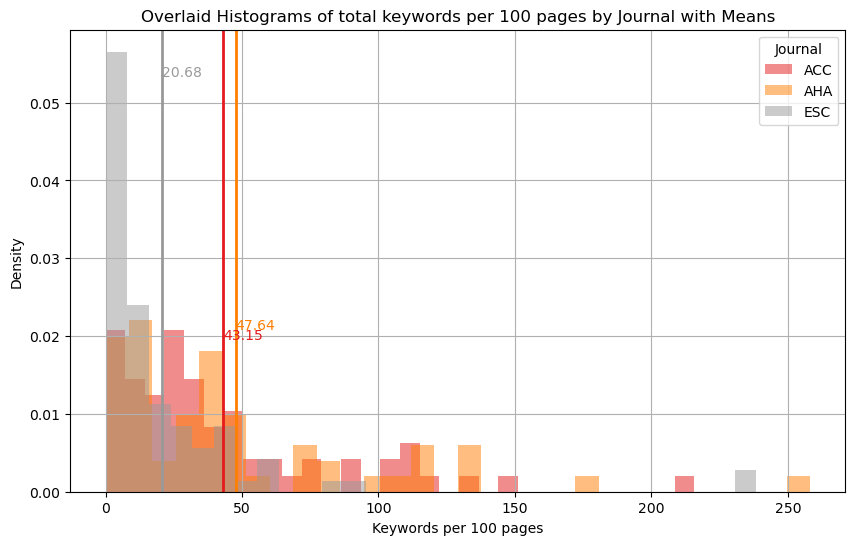

In [4]:
# Get the unique journal names
journals = data['Journal'].unique()

# Define the number of bins
bins = 30  # Adjust as needed

plt.figure(figsize=(10, 6))

# Use a broader color map (e.g., 'Set1', 'viridis', or others)
colors = plt.cm.get_cmap('Set1', len(journals))  # Use a broader palette with enough colors

# Loop through each journal and plot the histogram
for i, journal in enumerate(journals):
    subset = data[data['Journal'] == journal]
    
    # Plot the histogram for the journal
    plt.hist(subset['keywords per 100 pages'], bins=bins, alpha=0.5, label=journal, density=True, color=colors(i))
    
    # Plot the median for the current journal (full line with matching color)
    mean_value = subset['keywords per 100 pages'].mean()
    plt.axvline(mean_value, color=colors(i), linestyle='-', linewidth=2)  # Full line, no label
    
    # Add text for the median value
    plt.text(mean_value, plt.ylim()[1]*0.9, f'{mean_value:.2f}', color=colors(i), fontsize=10)

# Add labels and title
plt.xlabel('Keywords per 100 pages')
plt.ylabel('Density')
plt.title('Overlaid Histograms of total keywords per 100 pages by Journal with Means')
plt.legend(title='Journal')
plt.grid(True)
plt.show()


In [5]:
# Group data by journal
acc = data[data['Journal'] == 'ACC']['keywords per 100 pages']
aha = data[data['Journal'] == 'AHA']['keywords per 100 pages']
esc = data[data['Journal'] == 'ESC']['keywords per 100 pages']

# Check Normality using Shapiro-Wilk test
print("Normality test (Shapiro-Wilk):")
print(f"ACC: {shapiro(acc)}")
print(f"AHA: {shapiro(aha)}")
print(f"ESC: {shapiro(esc)}")

# Check Homogeneity of Variances using Levene's test
stat, p_value = levene(acc, aha, esc)
print(f"Levene's test for equal variances: Stat = {stat}, p-value = {p_value}")

# Perform One-Way ANOVA (valid if normality and homogeneity of variances are satisfied)
# Note: Tests the null hypothesis that two or more groups have the same population mean.
f_stat, p_value = f_oneway(acc, aha, esc)
print(f"ANOVA result: F-statistic = {f_stat}, p-value = {p_value}")

# Perform Kruskal-Wallis H Test (valid if normality and homogeneity of variance are not satisfied)
# Note: Tests the null hypothesis that the population median of all of the groups are equal.
stat, p_value = kruskal(acc, aha, esc)
print(f"Kruskal-Wallis H Test Statistic: {stat}, p-value: {p_value}")

Normality test (Shapiro-Wilk):
ACC: ShapiroResult(statistic=0.8336591946801652, pvalue=3.366399828386168e-07)
AHA: ShapiroResult(statistic=0.8087295772595513, pvalue=3.198667627131e-07)
ESC: ShapiroResult(statistic=0.5231978169606736, pvalue=1.607416749679895e-15)
Levene's test for equal variances: Stat = 3.5156174673746543, p-value = 0.03148289335420419
ANOVA result: F-statistic = 8.626750453113456, p-value = 0.00025047151084777846
Kruskal-Wallis H Test Statistic: 32.49986101390853, p-value: 8.764857294908995e-08


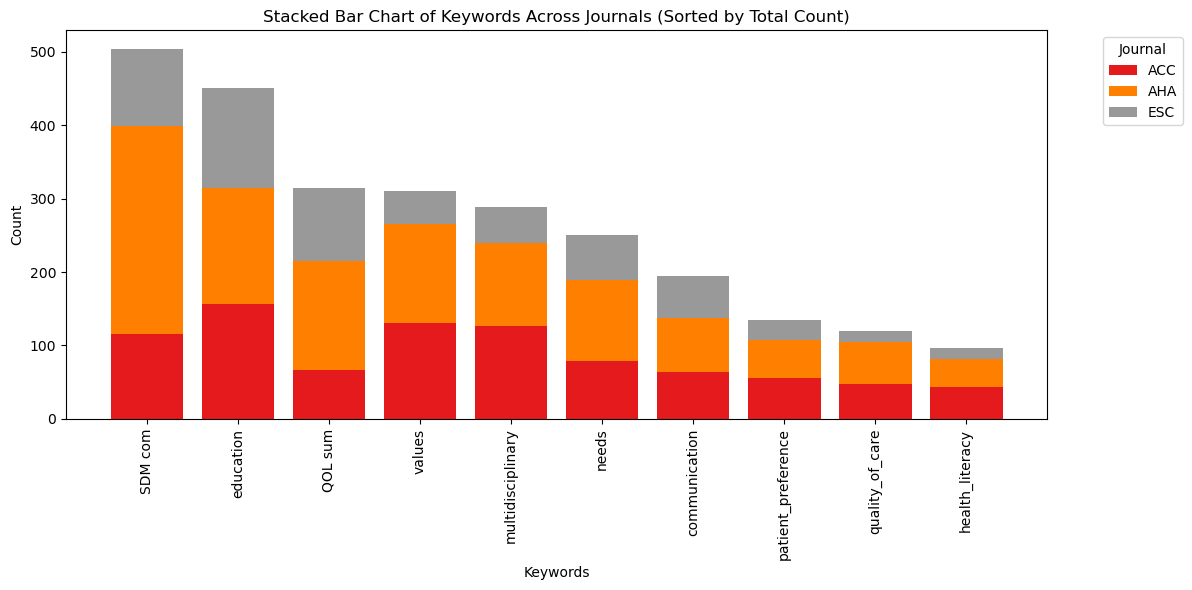

In [6]:

keyword_columns = data.columns[4:-3]

# Create a new grouped data where each keyword has a stacked bar for each journal
transposed_data = data.groupby('Journal')[keyword_columns].sum().T

# Sum the total values for each keyword across all journals and sort by descending order
keyword_totals = transposed_data.sum(axis=1).sort_values(ascending=False)

# Reorder the transposed data based on the sorted keywords
transposed_data_sorted = transposed_data.loc[keyword_totals.index]

# Keep only the top 10 keywords
transposed_data_sorted = transposed_data_sorted.head(10)

# Create the stacked bar chart with sorted keywords
fig, ax = plt.subplots(figsize=(12, 6))

# Create the bar plot for each journal and stack the bars
for i, journal in enumerate(journals):
    ax.bar(transposed_data_sorted.index, transposed_data_sorted[journal], 
           bottom=transposed_data_sorted.iloc[:, :i].sum(axis=1), label=journal, color=colors(i))

# Add labels and title
ax.set_xlabel('Keywords')
ax.set_ylabel('Count')
ax.set_title('Stacked Bar Chart of Keywords Across Journals (Sorted by Total Count)')
ax.legend(title='Journal', bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate x-axis labels for readability
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()